
# Image Captioning with **Qwen 2.5-VL**

This notebook shows how to:
1. load the 3-B-parameter **Qwen 2.5-VL-Instruct** model,  
2. send an image plus a natural-language request in “chat” format,  
3. receive an AI-generated caption, and  
4. visualise both the input image and the caption.  

*Runtime note:* The model uses ~6 GB VRAM in float-16 mode. If you are on a GPU without enough memory, set `device_map="cpu"` instead of `"auto"`.




# 1.Install necessary packages

In [1]:
!pip install -q qwen-vl-utils  # Upgrade Qwen-VL utilities

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 45.1 MB/s eta 0:00:00:00:0100:01


# 2.Imports

In [2]:
# ── Standard library ────────────────────────────────────────────
import os          # File‑system helpers (paths, env vars, etc.)
import random      # Lightweight randomness (e.g. sample prompts)
import textwrap    # Nicely format long strings for display
import io          # In‑memory byte streams (e.g. image buffers)
import requests    # Simple HTTP requests for downloading assets

# ── Numerical computing ─────────────────────────────────────────
import numpy as np  # Core array maths (fast, vectorised operations)

# ── Deep‑learning stack ─────────────────────────────────────────
import torch  # Tensor library + GPU acceleration
from transformers import (
    Qwen2_5_VLForConditionalGeneration,  # Multimodal LLM (image+text)
    AutoProcessor,                       # Paired tokenizer/feature‑extractor
)

# ── Imaging & visualisation ─────────────────────────────────────
from PIL import Image                    # Pillow: load/save/manipulate images
import matplotlib.pyplot as plt          # Quick plots in notebooks
import matplotlib.patches as patches     # Bounding‑box overlays, etc.

# ── Project‑specific helpers ────────────────────────────────────
from qwen_vl_utils import process_vision_info  # Post‑process Qwen outputs

# ── Notebook conveniences ──────────────────────────────────────
import IPython.display as ipd             # Inline display (images, audio, HTML)

2025-09-21 10:27:00.494635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758450420.855500      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758450420.957053      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 3.Device & model load

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "Qwen/Qwen2.5-VL-3B-Instruct"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype="auto",     # automatically uses FP16 on GPU, FP32 on CPU
    device_map="auto"       # dispatches layers to the available device(s)
)
processor = AutoProcessor.from_pretrained(model_id)

print(f"Model loaded on: {model.device}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

Model loaded on: cuda:0


# 4.Fetch or upload an image

In [4]:
# url = "https://plus.unsplash.com/premium_photo-1674375348357-a25140a68bbd?w=900&auto=format&fit=crop&q=60&ixlib=rb-4.1.0&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8Zml4aW5nJTIwY2FyfGVufDB8fDB8fHww"
# img = Image.open(io.BytesIO(requests.get(url, timeout=15).content)).convert("RGB")

# # Display the image
# plt.imshow(img)
# plt.axis("off")
# plt.title("Input image")
# plt.show()

## Multi Image Inference

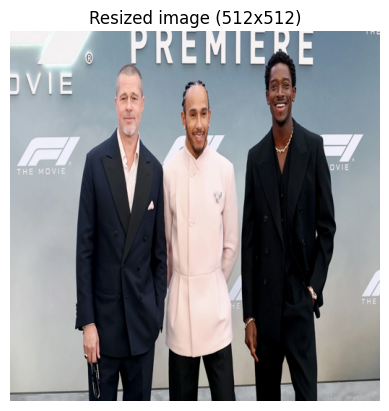

In [5]:
url1 = "https://media.formula1.com/image/upload/t_16by9Centre/c_lfill,w_3392/q_auto/v1740000000/fom-website/2025/F1%20movie/New%20York%20premiere/GENERAL%20CROP%20(25).webp"
img1 = Image.open(io.BytesIO(requests.get(url1, timeout=15).content)).convert("RGB")

# Resize to 512 x 512
img1_resized = img1.resize((512, 512))

# Display the resized image
plt.imshow(img1_resized)
plt.axis("off")
plt.title("Resized image (512x512)")
plt.show()

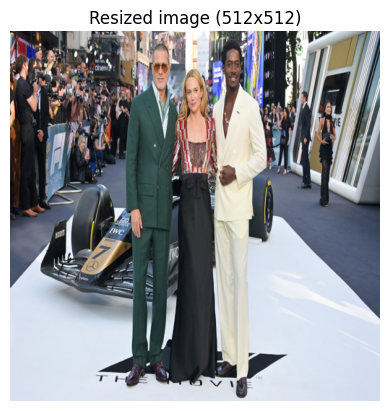

In [6]:
url2 = "https://www.apple.com/tv-pr/articles/2025/06/apple-original-films-celebrates-the-european-premiere-of-f1-the-movie-with-brad-pitt-damson-idris-kerry-condon-jerry-bruckheimer-lewis-hamilton-and-joseph-kosinski/images/big-image/big-image-01/062325_F1_The_Movie_European_Premiere_Event_Big_Image_01_big_image_post.jpg.large_2x.jpg"
img2 = Image.open(io.BytesIO(requests.get(url2, timeout=15).content)).convert("RGB")

# Resize to 512 x 512
img2_resized = img2.resize((512, 512))

# Display the resized image
plt.imshow(img2_resized)
plt.axis("off")
plt.title("Resized image (512x512)")
plt.show()

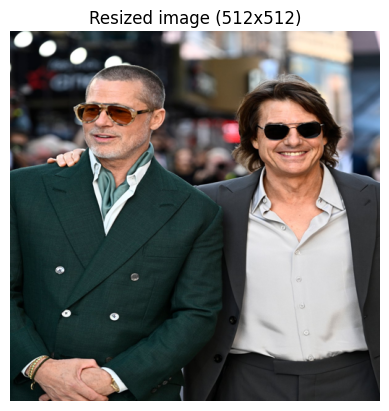

In [7]:
url3 = "https://static.standard.co.uk/2025/06/23/19/55/F1-The-Movie-European-Premiere-VIP-Arrivals-egmooazi.jpeg?width=1200"

img3 = Image.open(io.BytesIO(requests.get(url3, timeout = 15).content)).convert("RGB")

# Resize to 512 x 512
img3_resized = img3.resize((512, 512))

# Display the resized image
plt.imshow(img3_resized)
plt.axis("off")
plt.title("Resized image (512x512)")
plt.show()

# 5.Build a chat-style prompt


### 5.1 Create a message in JSON format
Qwen VL uses the same multi-turn message format as Qwen-2.5-Chat:
 ```python
 msgs = [
     { "role": "user",
       "content": [
           {"type": "image", "image": img},
           {"type": "text",  "text": "Describe this image."}
       ],
     }
 ]
 ```
The processor turns these messages into plain text (with special tokens) and extracts the visual tensors so the model receives *both* modalities.

## Defining the message for our image captioning task

In [8]:
message = [
    {
        "role":"system",
        "content":"You are a professional celebrity photographer, who works in hollywood industry" # defining how the model should behave
        
    },
    {
        "role":"user", # giving input to the model
        "content":[
            {
                "type":"image",
                "image":img1_resized # image 1
            },
            {
                "type":"image",
                "image":img2_resized # image 2
            },
            {
                "type":"image",
                "image":img3_resized # image 3
            },
            
            {
                "type":"text",
                "text":"Describe similarities between the three images, identify the hollywood celebrites, Count the number of male and female. Describe the colour of their attire"
            }
        ]
    }
]

### 5.2 Apply Chat Template
Every chat model ships with a pattern. The above JSON format needs to be converted to this template and this is done using `apply_chat_template`. It performs three tasks.
1. **Reads the model’s chat template**: Qwen 2.5VL has a chat template that looks like `<|im_start|>{role}\n{content}<|im_end|>`.
2. **Fills in the template with the message list**. It loops over each message, swaps in the role (user, assistant, etc.) and the content (text plus special <image> markers), and concatenates the result into one long string.
3. **Adds the “assistant starts talking now” marker** (add_generation_prompt=True). At the end it appends `<|im_start|>assistant`

We have also instructed it to NOT tokenize the text because we are going to use the processor to process text and images together, and tokenization will be performed in that step.

In [9]:
# Build the full textual prompt that Qwen-VL expects
# --------------------------------------------------
# • message : list of message dicts (roles + content, including <image> markers)

# • tokenize=False : return a plain string—not token IDs—so we can
#                    combine it with image tensors in the next processor() call

# • add_generation_prompt=True : appends the “assistant is about to speak” marker
#                                (e.g. "<|im_start|>assistant\n"), which tells the
#                                model where its reply should begin.

In [10]:
text_prompt = processor.apply_chat_template(
    message,

    tokenize = False,

    add_generation_prompt = True
)

# For sanity-checking: print the raw prompt string that will be fed to the model
print(text_prompt)

<|im_start|>system
You are a professional celebrity photographer, who works in hollywood industry<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|><|vision_start|><|image_pad|><|vision_end|><|vision_start|><|image_pad|><|vision_end|>Describe similarities between the three images, identify the hollywood celebrites, Count the number of male and female. Describe the colour of their attire<|im_end|>
<|im_start|>assistant



# 5.3 Extract image & video inputs from `message`

## In the previous step we converted our message `message` from JSON format to the chat template the model understands.

### Now, we need to extract images and videos from `msg` using `process_vision_info` utility. It performs the following tasks
1. Walks through every message,
2. Finds all `"image"` / `"video"` entries,
3. Applies the Qwen-VL visual pre-processing to ensure each image is a PIL.Image (or each video is a list / tensor of frames).
4. Returns two parallel lists/tensors
 - `image_inputs`  → batched image tensors (or [] if none)
 - `video_inputs`  → batched video tensors (or [] if none)

In [11]:
# Extract vision-modalities from msgs and convert them to model-ready tensors
# --------------------------------------------------------------------------
# • message : the same chat-style list you fed to apply_chat_template.
#          Each dict can include items like {"type": "image", "image": img}
#          or {"type": "video", "video": video_clip}.

# • process_vision_info : project utility that
#       1) walks through every message,
#       2) finds all `"image"` / `"video"` entries,
#       3) applies the Qwen-VL visual pre-processing to ensure each
#          image is a PIL.Image (or each video is a list / tensor of frames).
#       4) returns two parallel lists/tensors:
#            – `image_inputs`  → batched image tensors (or [] if none)
#            – `video_inputs`  → batched video tensors (or [] if none)


#   These outputs plug straight into the `processor(...)` call that follows,
#   ensuring the vision data is aligned with the text prompt.

In [12]:
image_inputs, video_inputs = process_vision_info(message)

In [13]:
image_inputs

[<PIL.Image.Image image mode=RGB size=504x504>,
 <PIL.Image.Image image mode=RGB size=504x504>,
 <PIL.Image.Image image mode=RGB size=504x504>]

In [14]:
# we gave 2 images to the model, 

### Multi image inference is possible, but the images has to be resized

# 6.Generate the caption

## 6.1 Run inference

## To run inference first we need to pack our 3 images and text prompt together inside the inputs variable

In [15]:
# ── Pack text + vision into model-ready tensors ──────────────────────────────
inputs = processor(
    
    text=[text_prompt],      # 1-element batch containing the chat prompt string
    
    images=image_inputs,     # list of raw PIL images (pre-processed inside processor)
    
    videos=video_inputs,     # list of raw video clips (if any)
    
    padding=True,            # pad sequences so text/vision tokens line up in a batch
    
    return_tensors="pt",     # return a dict of PyTorch tensors (input_ids, pixel_values, …)
    
).to(model.device)           # move every tensor—text & vision—to the model’s GPU/CPU

## What is inside the ``inputs``

In [16]:
inputs

{'input_ids': tensor([[151644,   8948,    198,  ..., 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[ 1.7698,  1.7698,  1.7844,  ...,  1.9610,  1.9610,  1.9610],
        [ 1.8135,  1.8135,  1.7844,  ...,  1.9610,  1.9753,  1.9753],
        [ 1.7552,  1.7698,  1.7698,  ...,  1.2500,  1.2216,  1.2643],
        ...,
        [-1.4127, -1.4127, -1.4419,  ..., -1.2243, -1.1105, -0.8688],
        [-1.2083, -1.2229, -1.2521,  ..., -0.9683, -0.9683, -0.9683],
        [-1.3835, -1.4127, -1.4565,  ..., -1.1674, -1.1816, -1.1816]],
       device='cuda:0'), 'image_grid_thw': tensor([[ 1, 36, 36],
        [ 1, 36, 36],
        [ 1, 36, 36]], device='cuda:0')}

In [17]:
inputs.input_ids

tensor([[151644,   8948,    198,  ..., 151644,  77091,    198]],
       device='cuda:0')

In [18]:
inputs.attention_mask

tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')

In [19]:
inputs.pixel_values

tensor([[ 1.7698,  1.7698,  1.7844,  ...,  1.9610,  1.9610,  1.9610],
        [ 1.8135,  1.8135,  1.7844,  ...,  1.9610,  1.9753,  1.9753],
        [ 1.7552,  1.7698,  1.7698,  ...,  1.2500,  1.2216,  1.2643],
        ...,
        [-1.4127, -1.4127, -1.4419,  ..., -1.2243, -1.1105, -0.8688],
        [-1.2083, -1.2229, -1.2521,  ..., -0.9683, -0.9683, -0.9683],
        [-1.3835, -1.4127, -1.4565,  ..., -1.1674, -1.1816, -1.1816]],
       device='cuda:0')

In [20]:
inputs.image_grid_thw

tensor([[ 1, 36, 36],
        [ 1, 36, 36],
        [ 1, 36, 36]], device='cuda:0')

In [21]:
# ── Run inference (no gradients, pure generation) ───────────────────────────
with torch.no_grad():                     # disable autograd to save memory
    
    generated_ids = model.generate(       # autoregressive decoding
        **inputs,                         # unpack dict into generate(...)
        max_new_tokens= 500                # cap the response at 100 tokens
    )
    
print(inputs.input_ids[0])
print(generated_ids)

tensor([151644,   8948,    198,  ..., 151644,  77091,    198], device='cuda:0')
tensor([[151644,   8948,    198,  ...,  29356,     13, 151645]],
       device='cuda:0')


## 6.2 Decode output

In [22]:
# Extract the newly generated tokens (skip the prompt length)

caption = processor.batch_decode(
    generated_ids[:, inputs.input_ids.shape[-1]:],
    
    skip_special_tokens=True
    
)[0]

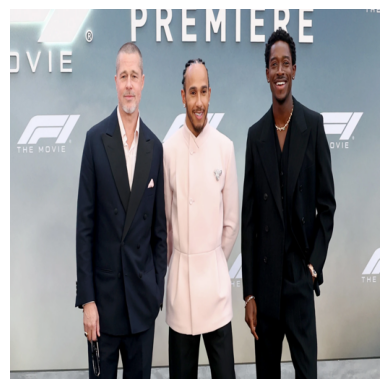

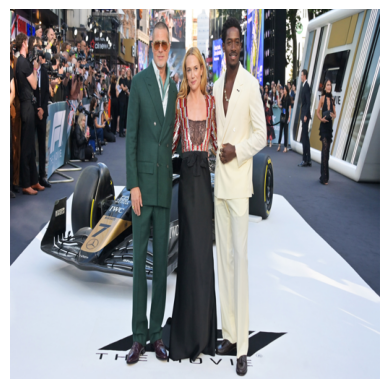

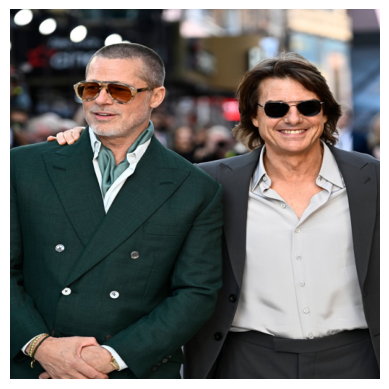

The three images depict different scenes from the "F1: The Movie" premiere
event. Here are the details:  ### Similarities: 1. **Event Setting**: All three
images are set at a red carpet event for the "F1: The Movie" premiere. 2.
**Attire**: The individuals in all three images are dressed in formal attire,
including suits and dresses.  ### Hollywood Celebrities: 1. **Image 1**:    -
**Left**: Brad Pitt    - **Middle**: Lewis Hamilton    - **Right**: John Boyega
2. **Image 2**:    - **Left**: Brad Pitt    - **Right**: Michael Douglas  3.
**Image 3**:    - **Left**: Brad Pitt    - **Right**: Michael Douglas  ###
Number of Male and Female: - **Male**: 4 (Brad Pitt, Lewis Hamilton, John
Boyega, Michael Douglas) - **Female**: 1 (Diane Kruger)  ### Color of Attire: -
**Brad Pitt**: Wearing a dark green suit with a white shirt and a light green
scarf. - **Lewis Hamilton**: Wearing a light pink suit with a white shirt. -
**John Boyega**: Wearing a black suit with a white shirt. - **Michael Doug

In [23]:
# Display the image
plt.imshow(img1_resized)
plt.axis("off")
plt.show()

plt.imshow(img2_resized)
plt.axis("off")
plt.show()

plt.imshow(img3_resized)
plt.axis("off")
plt.show()

# Print caption
width = 80
wrapped_caption = textwrap.fill(caption, width)
print(wrapped_caption)